# Subreddit Classification

This code uses an AlexNet model to classify an image to one of 20 subreddits.

## Load Datasets

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from model import Model, lazy_property
from config import ModelConfig, TrainConfig
import hyperopt as hpropt
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

In [2]:
# Form training, developement, and testing data sets
address = r'/home/tylerchase/CS-231N-Final-Project/data/fullData//'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train subreddit labels shape: ', data.y_train.shape)
print('Train nsfw labels shape: ', data.y_train_2.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation subreddit labels shape: ', data.y_val.shape)
print('Validation nsfw labels shape: ', data.y_val_2.shape)
print('Test data shape: ', data.X_test.shape)
print('Test subreddit labels shape: ', data.y_test.shape)
print('Test nsfw labels shape: ', data.y_test_2.shape)

Train data shape:  (25450, 128, 128, 3)
Train subreddit labels shape:  (25450,)
Train nsfw labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation subreddit labels shape:  (3181,)
Validation nsfw labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test subreddit labels shape:  (3182,)
Test nsfw labels shape:  (3182,)


## Optional Cell to take Particular Subreddits from Dataset

In [ ]:
subreddits = ['gonewild', 'ladybonersgw', 'PrettyGirls', 'LadyBoners']
dictionary = sample_data(subreddits, data, dictionary)

## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2


* affine layer from 4096 to 2048
* ReLU activation
* affine layer from 2048 to 2048
* ReLU activation
* affine layer from 2048 to 20

In [3]:
class AlexNet(Model):
    
    def __init__(self, model_config):
        Model.__init__(self, model_config)
  
    @lazy_property
    def prediction(self):
        # define our graph (e.g. AlexNet)
        
        a1 = tf.layers.conv2d(self.X_placeholder, filters=96, kernel_size=(11,11), strides=(4,4), padding='SAME') 
        h1 = tf.nn.relu(a1)
        mp1 = tf.layers.max_pooling2d(h1, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn1 = tf.layers.batch_normalization(mp1, training=self.is_training_placeholder)
        
        a2 = tf.layers.conv2d(bn1, filters=256, kernel_size=(5,5), strides=(1,1), padding='SAME')     
        h2 = tf.nn.relu(a2)
        mp2 = tf.layers.max_pooling2d(h2, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn2 = tf.layers.batch_normalization(mp2, training=self.is_training_placeholder)              
    
        a3 = tf.layers.conv2d(bn2, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h3 = tf.nn.relu(a3)
        a4 = tf.layers.conv2d(h3, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')   
        h4 = tf.nn.relu(a4)
        a5 = tf.layers.conv2d(h4, filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h5 = tf.nn.relu(a5)
        mp3 = tf.layers.max_pooling2d(h5, pool_size=(3,3), strides=(2,2), padding='SAME')  
    
        mp_flat = tf.reshape(mp3,[-1,4096])
        aff1 = tf.layers.dense(mp_flat, 2048)
        h6 = tf.nn.relu(aff1)
        aff2 = tf.layers.dense(h6, 2048)
        h7 = tf.nn.relu(aff2)
        y_out = tf.layers.dense(h7, self.config.subreddit_class_size)
    
        return y_out        

## Optional Cell to Train the Model with Specific Hyperparameters

In [4]:
# Create model instance
tf.reset_default_graph()

model_config = ModelConfig(learning_rate=0.002415191698722241)
train_config = TrainConfig(num_epochs=20, train_batch_size=100, print_every=100, lr_decay=0.9942796985885708,\
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_subreddit_classification_postParamSearch')
model = AlexNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------
Batch 100/255 of epoch 1 finished in 22.024685 seconds
Batch 200/255 of epoch 1 finished in 18.376422 seconds
Epoch 1 training finished in 52.182650 seconds
train accuracy:14.8%
val accuracy:13.7%
Epoch 1 evaluation finished in 29.463164 seconds
---------------------------------------------------------
Batch 100/255 of epoch 2 finished in 18.279095 seconds
Batch 200/255 of epoch 2 finished in 18.302237 seconds
Epoch 2 training finished in 46.573318 seconds
train accuracy:30.6%
val accuracy:32.1%
Epoch 2 evaluation finished in 15.215468 seconds
---------------------------------------------------------
Batch 100/255 of epoch 3 finished in 18.285263 seconds
Batch 200/255 of epoch 3 finished in 18.322341 seconds
Epoch 3 training finished in 46.581445 seconds
train accuracy:34.0%
val accuracy:33.6%
Epoch 3 evaluation finished in 15.089796 seconds
---------------------------------------------------------
Batch 100/255 of epoch 4 finis

## Return Loss and Accuracy History for Model Above

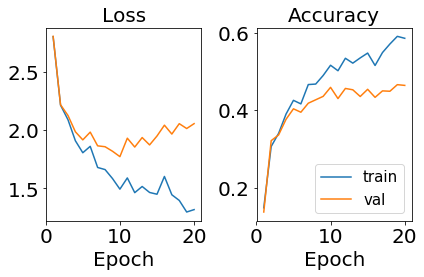

In [5]:
# Plot Loss and Accuracy
model.plot_loss_acc(data, save_address = '../../AlexNet_plots//', save_name = 'subreddit_history', \
    title_font = 20, tick_font = 20, legend_font = 15, axis_font = 20)

## Optional Cell for Hyperparameter Search over a Range of Hyperparameter Values

In [ ]:
model_config = ModelConfig(learning_rate=0.003)

train_config = TrainConfig(num_epochs=8, 
                    train_batch_size=100, 
                    print_every=1000)
modelHP = AlexNet(model_config)
session = tf.Session()

def objective(args):

    tf.reset_default_graph()
    modelHP = AlexNet(model_config)
    session = tf.Session()
    
    #train_config.num_epochs = args['Nepochs']
    train_config.lr_decay = args['decayRate']
    modelHP.config.learning_rate = args['learningRate']
    #modelHP.config.sbrd_weight = args['costWeight']
    
    modelHP.train(data, session, train_config)
    cost, accuracy = modelHP.eval(data, session, "val")
    
    saveList = {
        'accuracy_sbrd' : accuracy,
        'cost' : cost,
        #'Nepochs' : args['Nepochs'],
        'learningRate' : args['learningRate'],
        'decayRate' : args['decayRate']
        #'costWeight' : args['costWeight']
    }    
    pickle.dump(saveList, open("../../hprOpt_AlexNetSubreddit/hprPrmOpt_" + str(accuracy) + "_" + str(cost) + ".dat", "wb"))
    
    return cost

def optimize():
    
    space = {
        #'Nepochs' : hpropt.hp.randint('Nepochs', 70),
        'learningRate' : hpropt.hp.loguniform('learningRate', -8.1, -3.5),
        'decayRate' : hpropt.hp.uniform('decayRate', 0.95, 1)
        #'costWeight' : hpropt.hp.uniform('costWeight', 0.5, 1)
    }
    
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=100)
    print(best)
    
    return best

In [ ]:
optimize()

## Test Loading the Model

In [7]:
# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(learning_rate=0.002415191698722241)
train_config = TrainConfig(num_epochs=20, train_batch_size=100, print_every=100, lr_decay=0.9942796985885708,\
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_subreddit_classification_postParamSearch')
model = AlexNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, train_config.saver_address + train_config.save_file_name) 

# Test Model Accuracy
loss_train, acc_train = model.eval(data, session, split='train')
loss_val, acc_val = model.eval(data, session, split = 'val')

print('Training Accuracy {:3.1f}%, Vallidation Accuracy:{:3.1f}%'.format((100*acc_train), (100*acc_val)))

train accuracy:59.0%
val accuracy:46.6%
Training Accuracy 59.0%, Vallidation Accuracy:46.6%


## Output Predictions for Validation 

In [8]:
y_val_pred = session.run(model.prediction, {model.X_placeholder: data.X_val, model.y_placeholder: data.y_val, 
                                            model.is_training_placeholder:False})

y_val_pred = np.argmax(y_val_pred, axis = 1)

## Plot Confusion Matrix for Subreddit Classification

Normalized confusion matrix


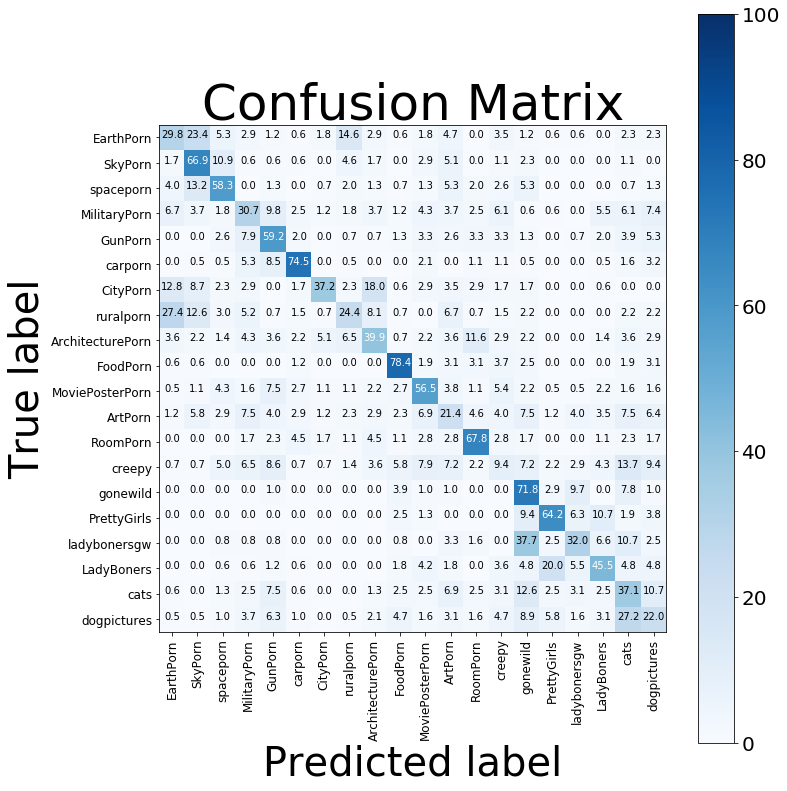

In [9]:
classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(data.y_val, y_val_pred)
'''
plot_confusion_matrix(conf, classes=classes, normalize = True, tick_font = 12, box_font = 10, \
    axis_font = 40, title_font = 50, colorbar_font = 20,\
    left_space = 0.2, right_space = 1, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../AlexNet_plots//', save_name = 'subreddit_confusion')
'''
plot_confusion_matrix(conf, classes=classes, normalize = True, task = 'subreddit', \
    save_address = '../../AlexNet_plots//', save_name = 'subreddit_confusion')

## Output Predictions for Test

In [10]:
test_cost, test_acc = model.eval(data, session, "test")


y_test_pred = session.run(model.prediction, {model.X_placeholder: data.X_test, model.y_placeholder: data.y_test, 
                                            model.is_training_placeholder:False})

y_test_pred = np.argmax(y_test_pred, axis = 1)

test accuracy:46.3%


## Plot Confusion Matrix for Test Data

Normalized confusion matrix


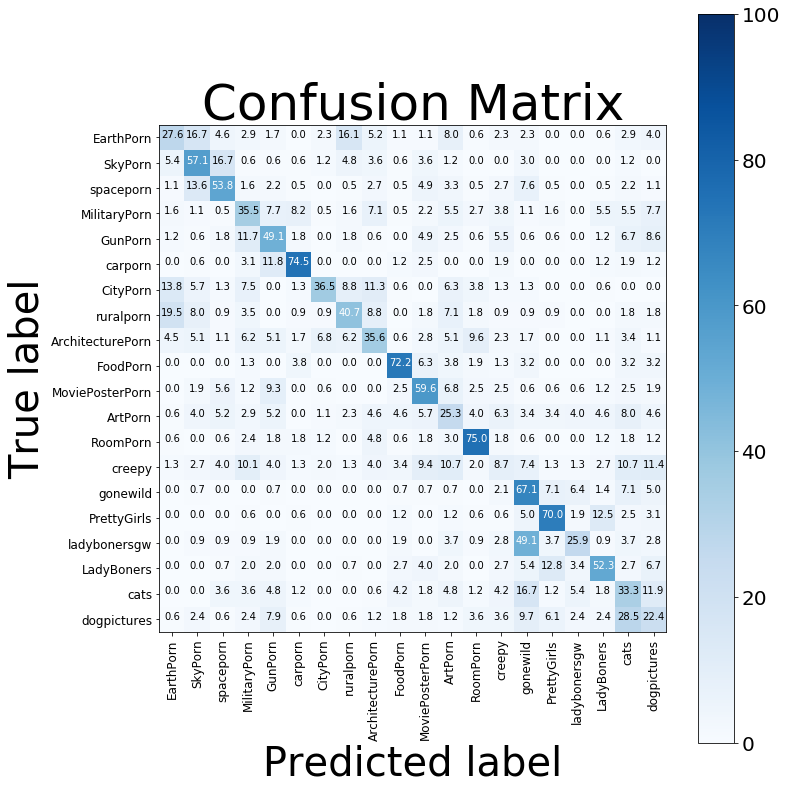

In [11]:
classes = [""] * len(dictionary)
for sub, ind in dictionary.items():
    classes[ind] = sub

conf = confusion_matrix(data.y_test, y_test_pred)
'''
plot_confusion_matrix(conf, classes=classes, normalize = True, tick_font = 12, box_font = 10, \
    axis_font = 40, title_font = 50, colorbar_font = 20,\
    left_space = 0.2, right_space = 1, top_space = 0.97, bottom_space = 0.05, \
    save_address = '../../AlexNet_plots//', save_name = 'subreddit_confusion_test')
'''
plot_confusion_matrix(conf, classes=classes, normalize = True, task = 'subreddit', \
    save_address = '../../AlexNet_plots//', save_name = 'subreddit_confusion_test')